###swc标注标准化

In [5]:
import numpy as np

def flip_y_axis(swc_file, output_file):
    # 加载SWC数据
    data = np.loadtxt(swc_file)
    
    # 获取Y坐标的最大值
    max_y = np.max(data[:, 3])
    
    # 翻转Y坐标
    data[:, 3] = max_y - data[:, 3]
    
    # 保存修改后的数据到新文件
    np.savetxt(output_file, data, fmt='%d %d %f %f %f %f %d')
    
# 使用方法示例
flip_y_axis('sample_data/2364.swc', 'sample_data/output_flipped.swc')


###sort swc


In [9]:
#vaa3d sort baseline
import subprocess

swc_in = 'sample_data/output_flipped.swc'
swc_out = 'sample_data/baseline_sorted.swc'

def sort_swc(swc_in, swc_out=None, v3d_path=r"C:\Users\SEU\Desktop\Vaa3D-x.1.1.4_Windows_64bit_version\Vaa3D-x.1.1.4_Windows_64bit_version\Vaa3D-x.exe"):
    cmd_str = f' {v3d_path} /x sort_neuron_swc /f sort_swc /i {swc_in} /o {swc_out}'
    #cmd_str = f'"{v3d_path}" /x sort_neuron_swc /f help'
    process = subprocess.Popen(cmd_str, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    
    if process.returncode != 0:
        print(f"Error: {stderr.decode()}")
    else:
        print(stdout.decode())

sort_swc(swc_in, swc_out)


[C:\Users\SEU\Desktop\Vaa3D-x.1.1.4_Windows_64bit_version\Vaa3D-x.1.1.4_Windows_64bit_version\Vaa3D-x.exe]
[/x]
[sort_neuron_swc]
[/f]
[sort_swc]
[/i]
[sample_data/output_flipped.swc]
[/o]
[sample_data/baseline_sorted.swc]
Current canonical path = [sort_neuron_swc]
plugins
==========Welcome to sort_swc function=============
No new parameter specified.
outfile: sample_data/baseline_sorted.swc
Done 1st DFS
swc/eswc file sample_data/baseline_sorted.swc has been generated, size: 876
Starting Vaa3D version checker...



In [8]:
#test_sort_swc on llm
import pandas as pd

def reorder_swc(swc_file, output_file):
    # 读取SWC文件
    data = pd.read_csv(swc_file, delim_whitespace=True, comment='#', header=None,
                       names=['id', 'type', 'x', 'y', 'z', 'radius', 'parent'])
    
    # 用于存储重排序后的数据
    reordered = pd.DataFrame(columns=data.columns)
    
    # 处理根节点（假设根节点的父节点为-1）
    root = data[data['parent'] == -1]
    reordered = reordered.append(root)
    
    # 添加根节点后的所有子节点和相应的子树
    def add_children(parent_id):
        children = data[data['parent'] == parent_id]
        for _, child in children.iterrows():
            reordered.loc[len(reordered)] = child
            add_children(child['id'])
    
    # 从根节点开始添加子节点
    add_children(root['id'].values[0])
    
    # 将重排序后的数据写入新的SWC文件
    reordered.to_csv(output_file, sep=' ', index=False, header=False)
    
# 使用方法示例
reorder_swc('sample_data/output_flipped.swc', 'sample_data/output_reordered.swc')


C:\Users\SEU\AppData\Local\Temp\ipykernel_70760\600252303.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reordered = reordered.append(root)


###soma_region(include fibers)

C:\Users\SEU\AppData\Local\Temp\ipykernel_70760\1097608036.py:33: UserWarning: soma_region.tif is a low contrast image
  io.imsave('soma_region.tif', soma_region.astype(np.uint8) * 255)


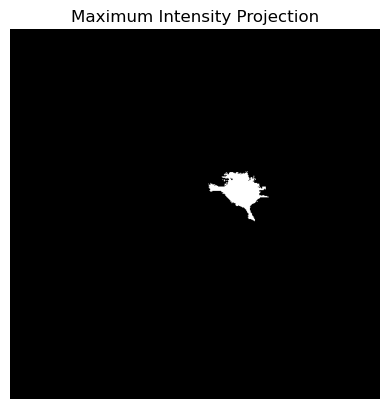

In [4]:
import numpy as np
from skimage import io, morphology, measure
from scipy.ndimage import binary_closing, binary_dilation
import matplotlib.pyplot as plt

# Load the 3D tif image

image = io.imread('sample_data/2364.tif')

# Step 1: Binarization 
threshold = image.max() * 0.5
b_img = image > threshold

# Step 2: Perform closing on the binary image
c_img = binary_closing(b_img, structure=np.ones((3, 3, 3)))

# Step 3: Extract the largest connected component containing the soma
labeled_img = measure.label(c_img, connectivity=3)
props = measure.regionprops(labeled_img, intensity_image=image)
largest_region = max(props, key=lambda x: x.area)

l_img = np.zeros_like(labeled_img)
for coord in largest_region.coords:
    l_img[coord[0], coord[1], coord[2]] = 1

# Step 4: Dilate the largest connected component
d_img = binary_dilation(l_img, structure=np.ones((3, 3, 3)))

# Step 5: Perform logical AND between b_img and d_img to get soma_region
soma_region = b_img & d_img

# Save or display the result
io.imsave('soma_region.tif', soma_region.astype(np.uint8) * 255)
# Generate the Maximum Intensity Projection (MIP)
mip = np.max(soma_region, axis=0)

# Save the MIP as a PNG file
plt.imshow(mip, cmap='gray')
plt.title('Maximum Intensity Projection')
plt.axis('off')
plt.savefig('mip.png', bbox_inches='tight', pad_inches=0)
plt.show()


###generate mask 
baseline: vaa3d /x neuron_radius /f neuron_radius  ## calculate radius of each swc node based on ori_img


In [5]:
#vaa3d neuron_radius baseline
import subprocess

img = 'sample_data/2364_ori.tif'
swc = 'sample_data/2364_baseline_sorted.swc'
swc_out = 'sample_data/2364_baseline_radius.swc'

def radius_swc(img,swc, swc_out,v3d_path=r"C:\Users\SEU\Desktop\Vaa3D-x.1.1.4_Windows_64bit_version\Vaa3D-x.1.1.4_Windows_64bit_version\Vaa3D-x.exe"):
    cmd_str = f' {v3d_path} /x neuron_radius /f neuron_radius /i {img}{swc} /o {swc_out}'
    #cmd_str = f'"{v3d_path}" /x neuron_radius /f help'
    process = subprocess.Popen(cmd_str, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    
    if process.returncode != 0:
        print(f"Error: {stderr.decode()}")
    else:
        print(stdout.decode())

radius_swc(img, swc,swc_out)

[C:\Users\SEU\Desktop\Vaa3D-x.1.1.4_Windows_64bit_version\Vaa3D-x.1.1.4_Windows_64bit_version\Vaa3D-x.exe]
[/x]
[neuron_radius]
[/f]
[neuron_radius]
[/i]
[sample_data/2364_ori.tifsample_data/2364_baseline_sorted.swc]
[/o]
[sample_data/2364_baseline_radius.swc]
The file format is not supported for Vaa3D -i option.
Current canonical path = [neuron_radius]
plugins
Fail to call plugin function.
Starting Vaa3D version checker...

